In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
import sklearn
from sklearn.preprocessing import LabelEncoder
import os

a. Image processing
==
1. Resizing method

Observations and experimentation:
64x64 as first pass
first image as 4 as 3rd param. (RGBA: transparency. need to see how to drop it, convert to rgb isn't enough)
8th image no 3rd param.
does not contain apple_34.
consider:
* kernel_size
* image augmentation: imageDataGen & cutMix, Mix
* colab -> GPU

observations for imgDataGen:
increasing batch-size from 1 to 5 greatly improves accuracy
batch size of 32, poor accuracy
change epochs from 100 to 500 has poorer result

In [32]:
from os.path import isfile
import glob

curr_dir = os.getcwd()
train_path = curr_dir + "/train/"
test_path = curr_dir + "/test/"
class_names = ["apple", "banana", "mixed", "orange"]

files_train = [img for img in glob.glob(train_path + "*.jpg")]
files_test = [img for img in glob.glob(test_path + "*.jpg")]

In [33]:
x_resize = 64
y_resize = 64


In [34]:
# TODO: write a function to create the directory automatically,
# if dir exists, do not create the dir..
def process_image(files, path, method):
    x = None
    y = []
    for i in range(len(files)):
        img = Image.open(files[i])
        img_resize = img.resize((x_resize, y_resize))
        if img_resize.mode in ["RGBA", "P"]:
            img_resize = img_resize.convert("RGB")
        if x is None:
            x = img_resize
        else:
            x = np.concatenate((x, img_resize))
        y.append(os.path.basename(files[i]).split('_')[0])
        img_name = os.path.basename(files[i]).split('.')[0]
        save_path = path + "resize/" + img_name
        save_image(img_resize, method, save_path)

    x = x.reshape(-1, x_resize, y_resize, 3)
    le = LabelEncoder()
    y = le.fit_transform(y)

    return x,y

def save_image(img, method, save_path):
    if method == 'resize':
        img.save(save_path + "_{}x{}.jpg".format(x_resize, y_resize))
    if method == 'image_data_gen':
        img.save(save_path + "idg.jpg")

In [35]:
x_train, y_train = process_image(files_train, train_path, 'resize')
x_test, y_test = process_image(files_test, test_path, 'resize')

/Users/xinyitay/miniforge3/envs/gdiptf/lib/python3.8/site-packages/PIL/Image.py:973: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [36]:
files_augmented_train = [img for img in glob.glob(train_path + "/resize/" + "*.jpg")]
files_augmented_test = [img for img in glob.glob(test_path + "/resize/" + "*.jpg")]


In [37]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(240, 64, 64, 3)
(60, 64, 64, 3)
(240,)
(60,)


In [38]:
# preview of images
def plot_summary_view(is_train):
    if is_train:
        x = x_train
        y = y_train
    else:
        x = x_test
        y = y_test

    plt.figure(figsize=(20,20))
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.grid(False)
        plt.imshow(x[i])
        plt.title(class_names[y[i]])
    plt.show()

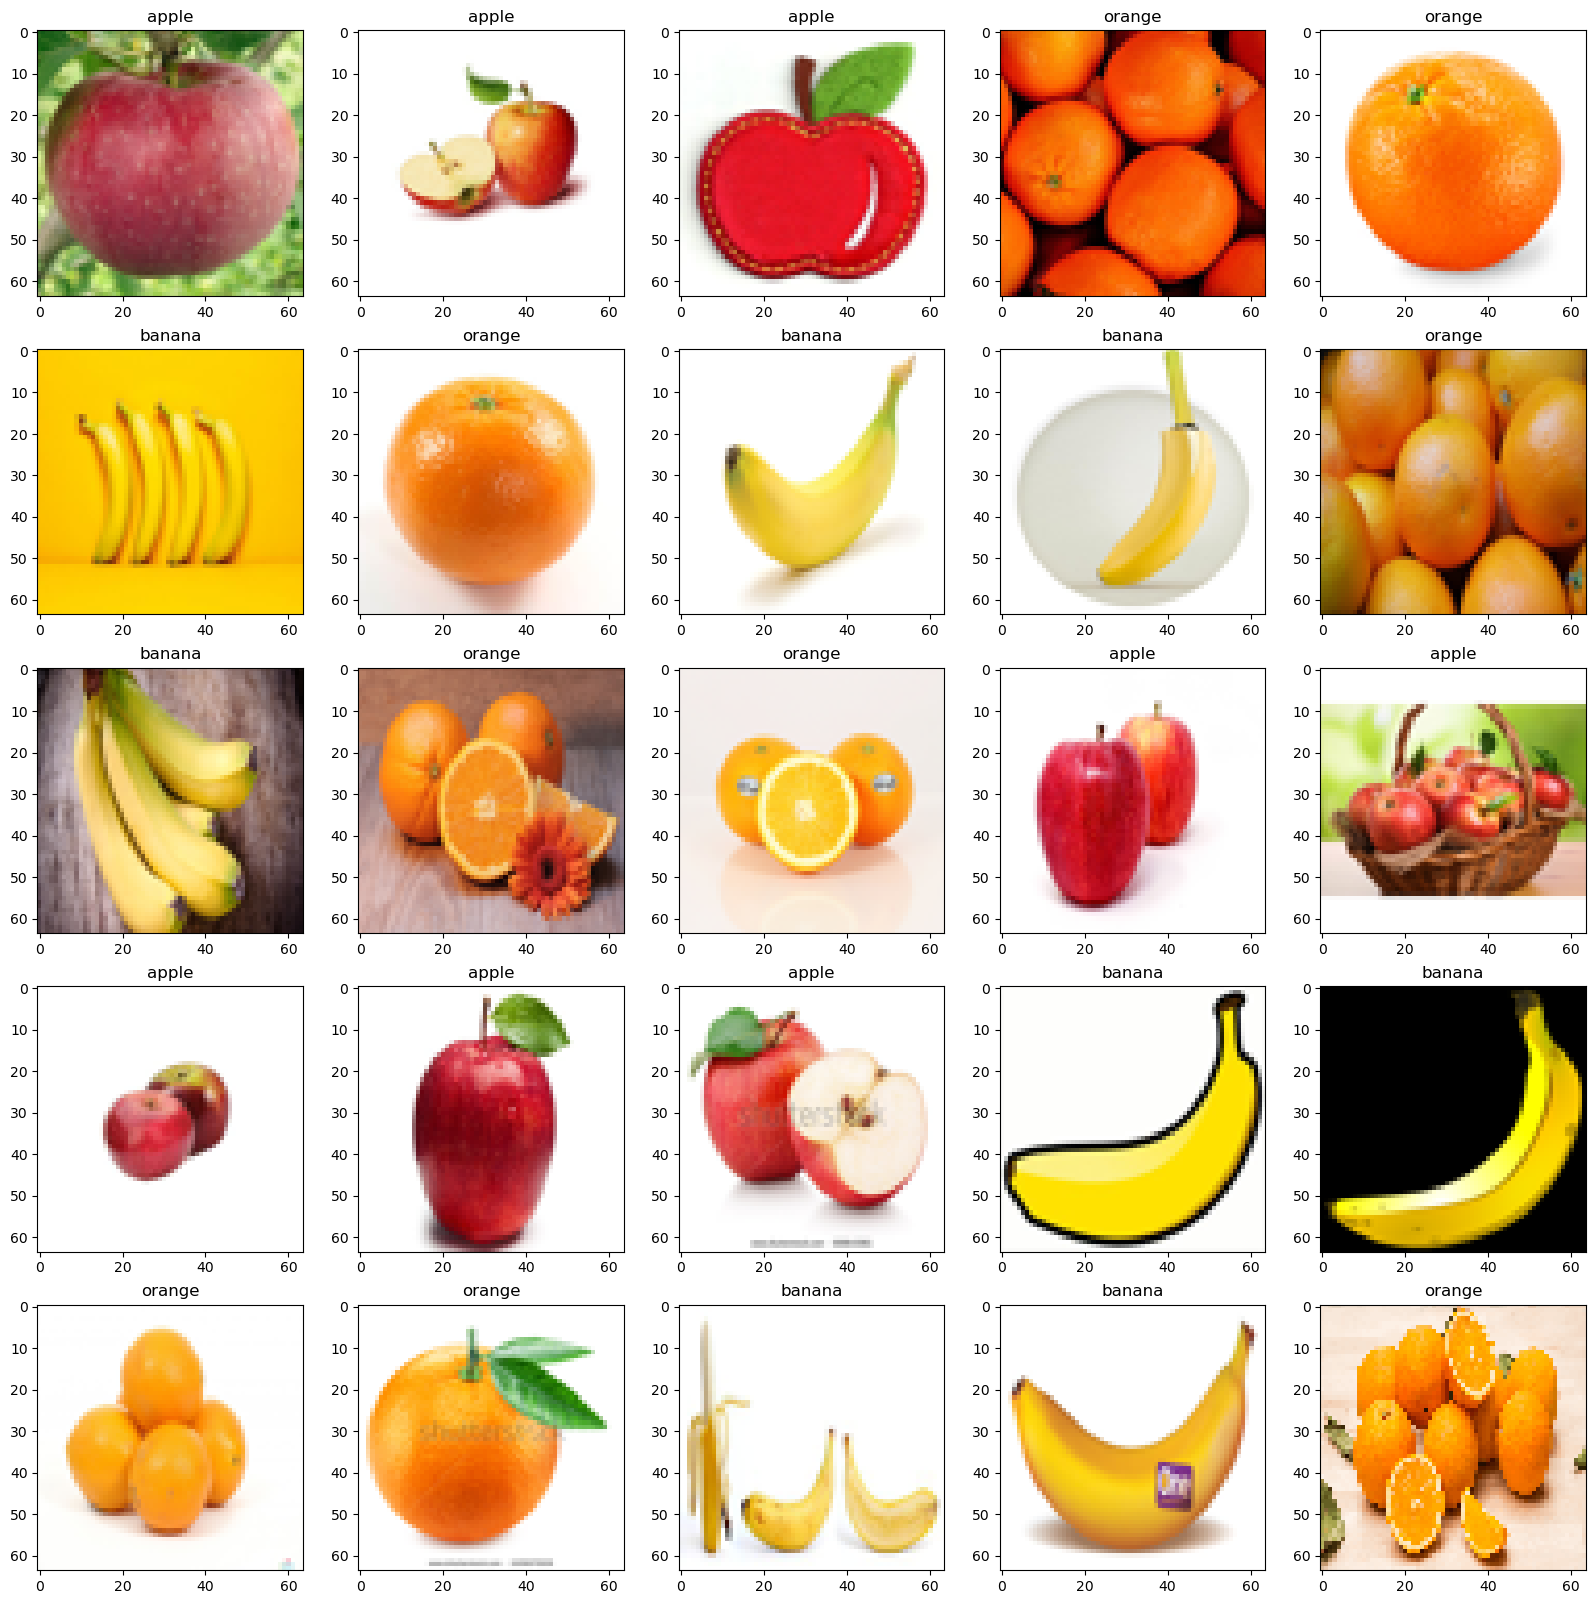

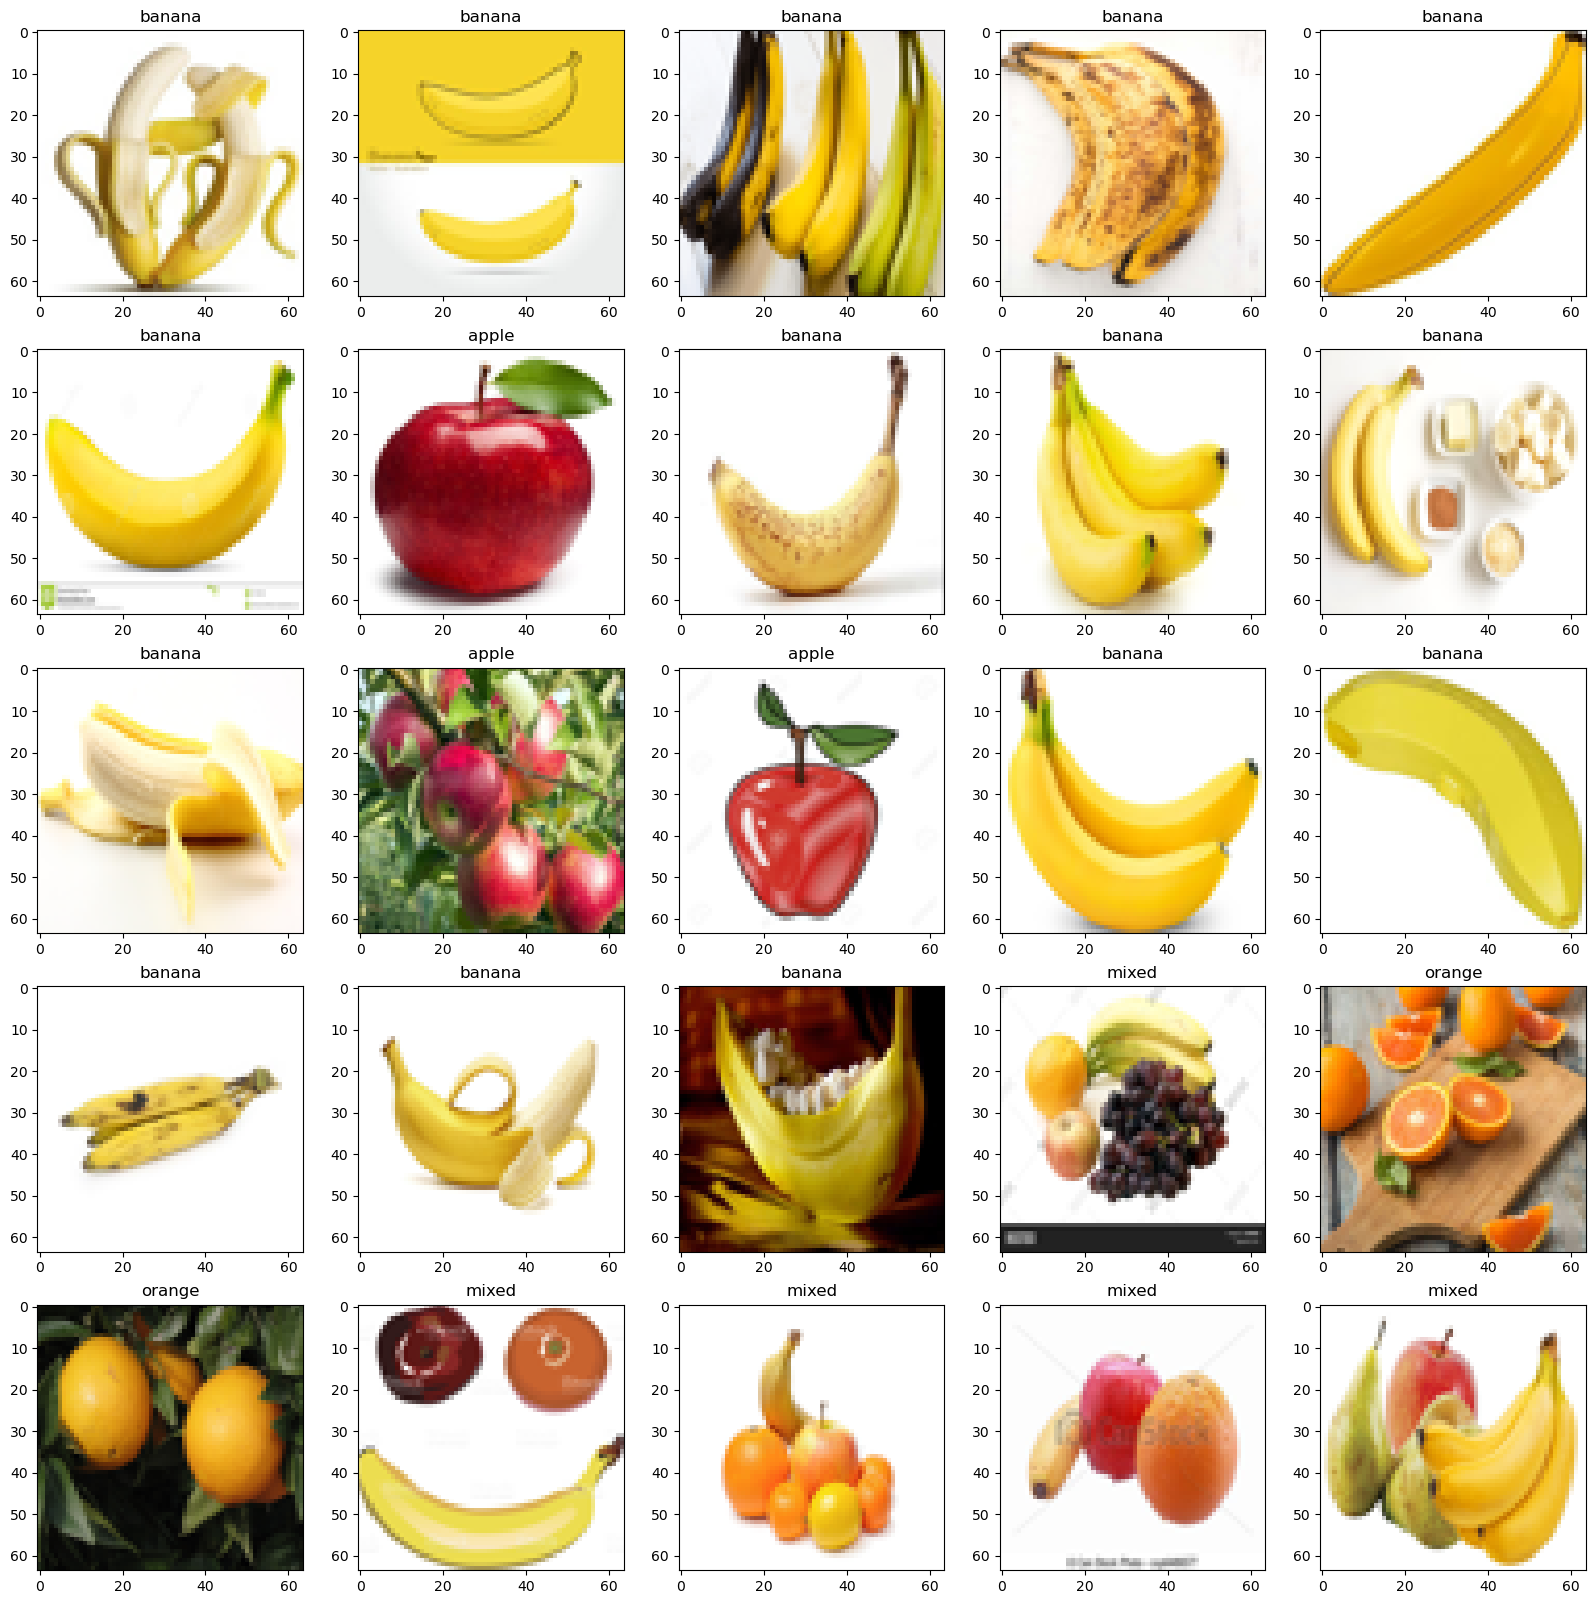

In [39]:
plot_summary_view(True)
plot_summary_view(False)

b. Prepare data for model fitting (normalize image data)
==

In [ ]:
# normalize
x_train = x_train/255
x_test = x_test/255

2.Using ImageDataGenerator by Keras

In [316]:
from keras_preprocessing.image import ImageDataGenerator

trainGen = ImageDataGenerator(
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True)

testGen = ImageDataGenerator(rescale = 1./255)

# takes some time to load btw.
train_generator = trainGen.flow(x=x_train, y=y_train, batch_size=25, shuffle=True, save_to_dir=train_path+"imgGen", save_format='jpg')
test_generator = testGen.flow(x=x_test, y=y_test, batch_size=25, shuffle=True, save_to_dir=test_path+"imgGen", save_format='jpg')

Using CutMix

In [317]:
# from cutmix_keras import CutMixImageDataGenerator
# trainGen = ImageDataGenerator(
#     rotation_range = 40,
#     width_shift_range = 0.2,
#     height_shift_range = 0.2,
#     rescale = 1./255,
#     shear_range = 0.2,
#     zoom_range = 0.2,
#     horizontal_flip = True)
#
# # flow from dataframe required for CutMix. same for MixUp
# trainGen1 = trainGen.flow(x=x_train, y=y_train, batch_size=15, shuffle=True, save_to_dir=train_path+"imgGen", save_format='jpg')
# trainGen2 = trainGen.flow(x=x_train, y=y_train, batch_size=15, shuffle=True, save_to_dir=train_path+"imgGen", save_format='jpg')
#
# testGen = ImageDataGenerator(rescale = 1./255)
# test_generator = testGen.flow(x=x_test, y=y_test, batch_size=15, shuffle=True, save_to_dir=test_path+"imgGen", save_format='jpg')
#
# train_generator = CutMixImageDataGenerator(
#         generator1=trainGen1,
#         generator2=trainGen2,
#         img_size=64,
#         batch_size=15
#     )

c. Build the model
==

In [318]:
#0.3 loss initially, kernel 5,5 and 9,9
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(filters=32,
                                 kernel_size=(5,5),
                                 activation='relu',
                                 input_shape=(x_resize, y_resize, 3)))
model.add(tf.keras.layers.Conv2D(filters=32,
                                 kernel_size=(9,9),
                                 activation='relu'))

model.add(tf.keras.layers.MaxPooling2D(pool_size=(3,3)))
model.add(tf.keras.layers.Dropout(rate=0.2))
# flatten layer into 1d before sending to dense
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=256, activation='relu'))
model.add(tf.keras.layers.Dense(units=128, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.5))
model.add(tf.keras.layers.Dense(units=len(class_names), activation='softmax'))

In [319]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=['accuracy'])

In [320]:
# hist = model.fit(x_train, y_train, batch_size=10, epochs=100)

In [321]:
#if training using ImgDataGen
hist = model.fit_generator(train_generator,
                           validation_data=test_generator,
                           steps_per_epoch=10,
                           validation_steps=10,
                           epochs=100)

Epoch 1/100
10/10 [==============================] - 2s 115ms/step - batch: 4.5000 - size: 24.0000 - loss: 1.5368 - accuracy: 0.2667 - val_loss: 1.3354 - val_accuracy: 0.3707
Epoch 2/100
10/10 [==============================] - 1s 86ms/step - batch: 4.5000 - size: 24.0000 - loss: 1.2827 - accuracy: 0.3792 - val_loss: 1.1876 - val_accuracy: 0.5220

d. Test our model
==

Observe the loss and accuracy over training

In [326]:
loss, accuracy = model.evaluate(x_test,y_test)

print(loss)
print(accuracy)

79.06605072021485
0.9166667


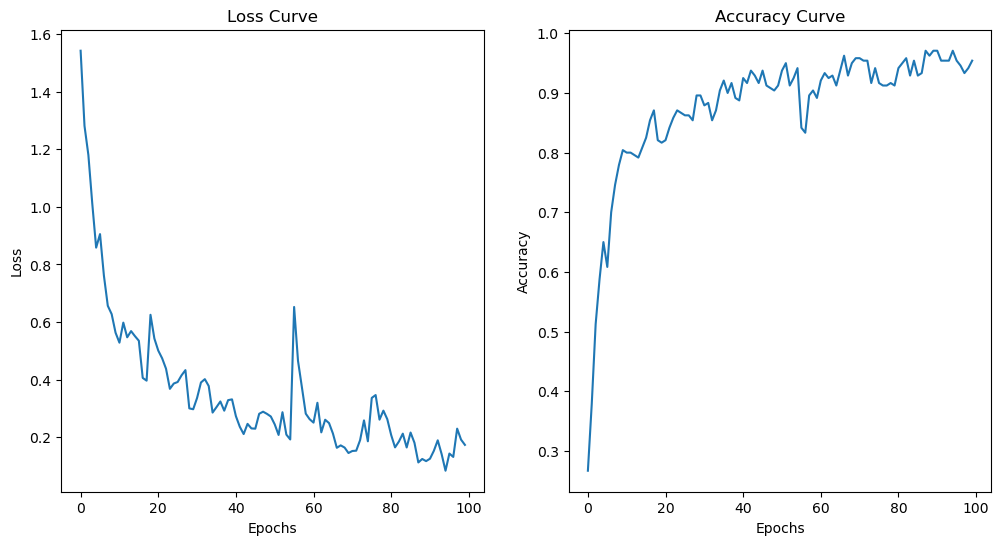

In [327]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
plt
ax[0].plot(hist.history['loss'])
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Loss Curve')

ax[1].plot(hist.history['accuracy'])
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Accuracy Curve')

plt.show()

In [328]:
predictions = model.predict(x_test)

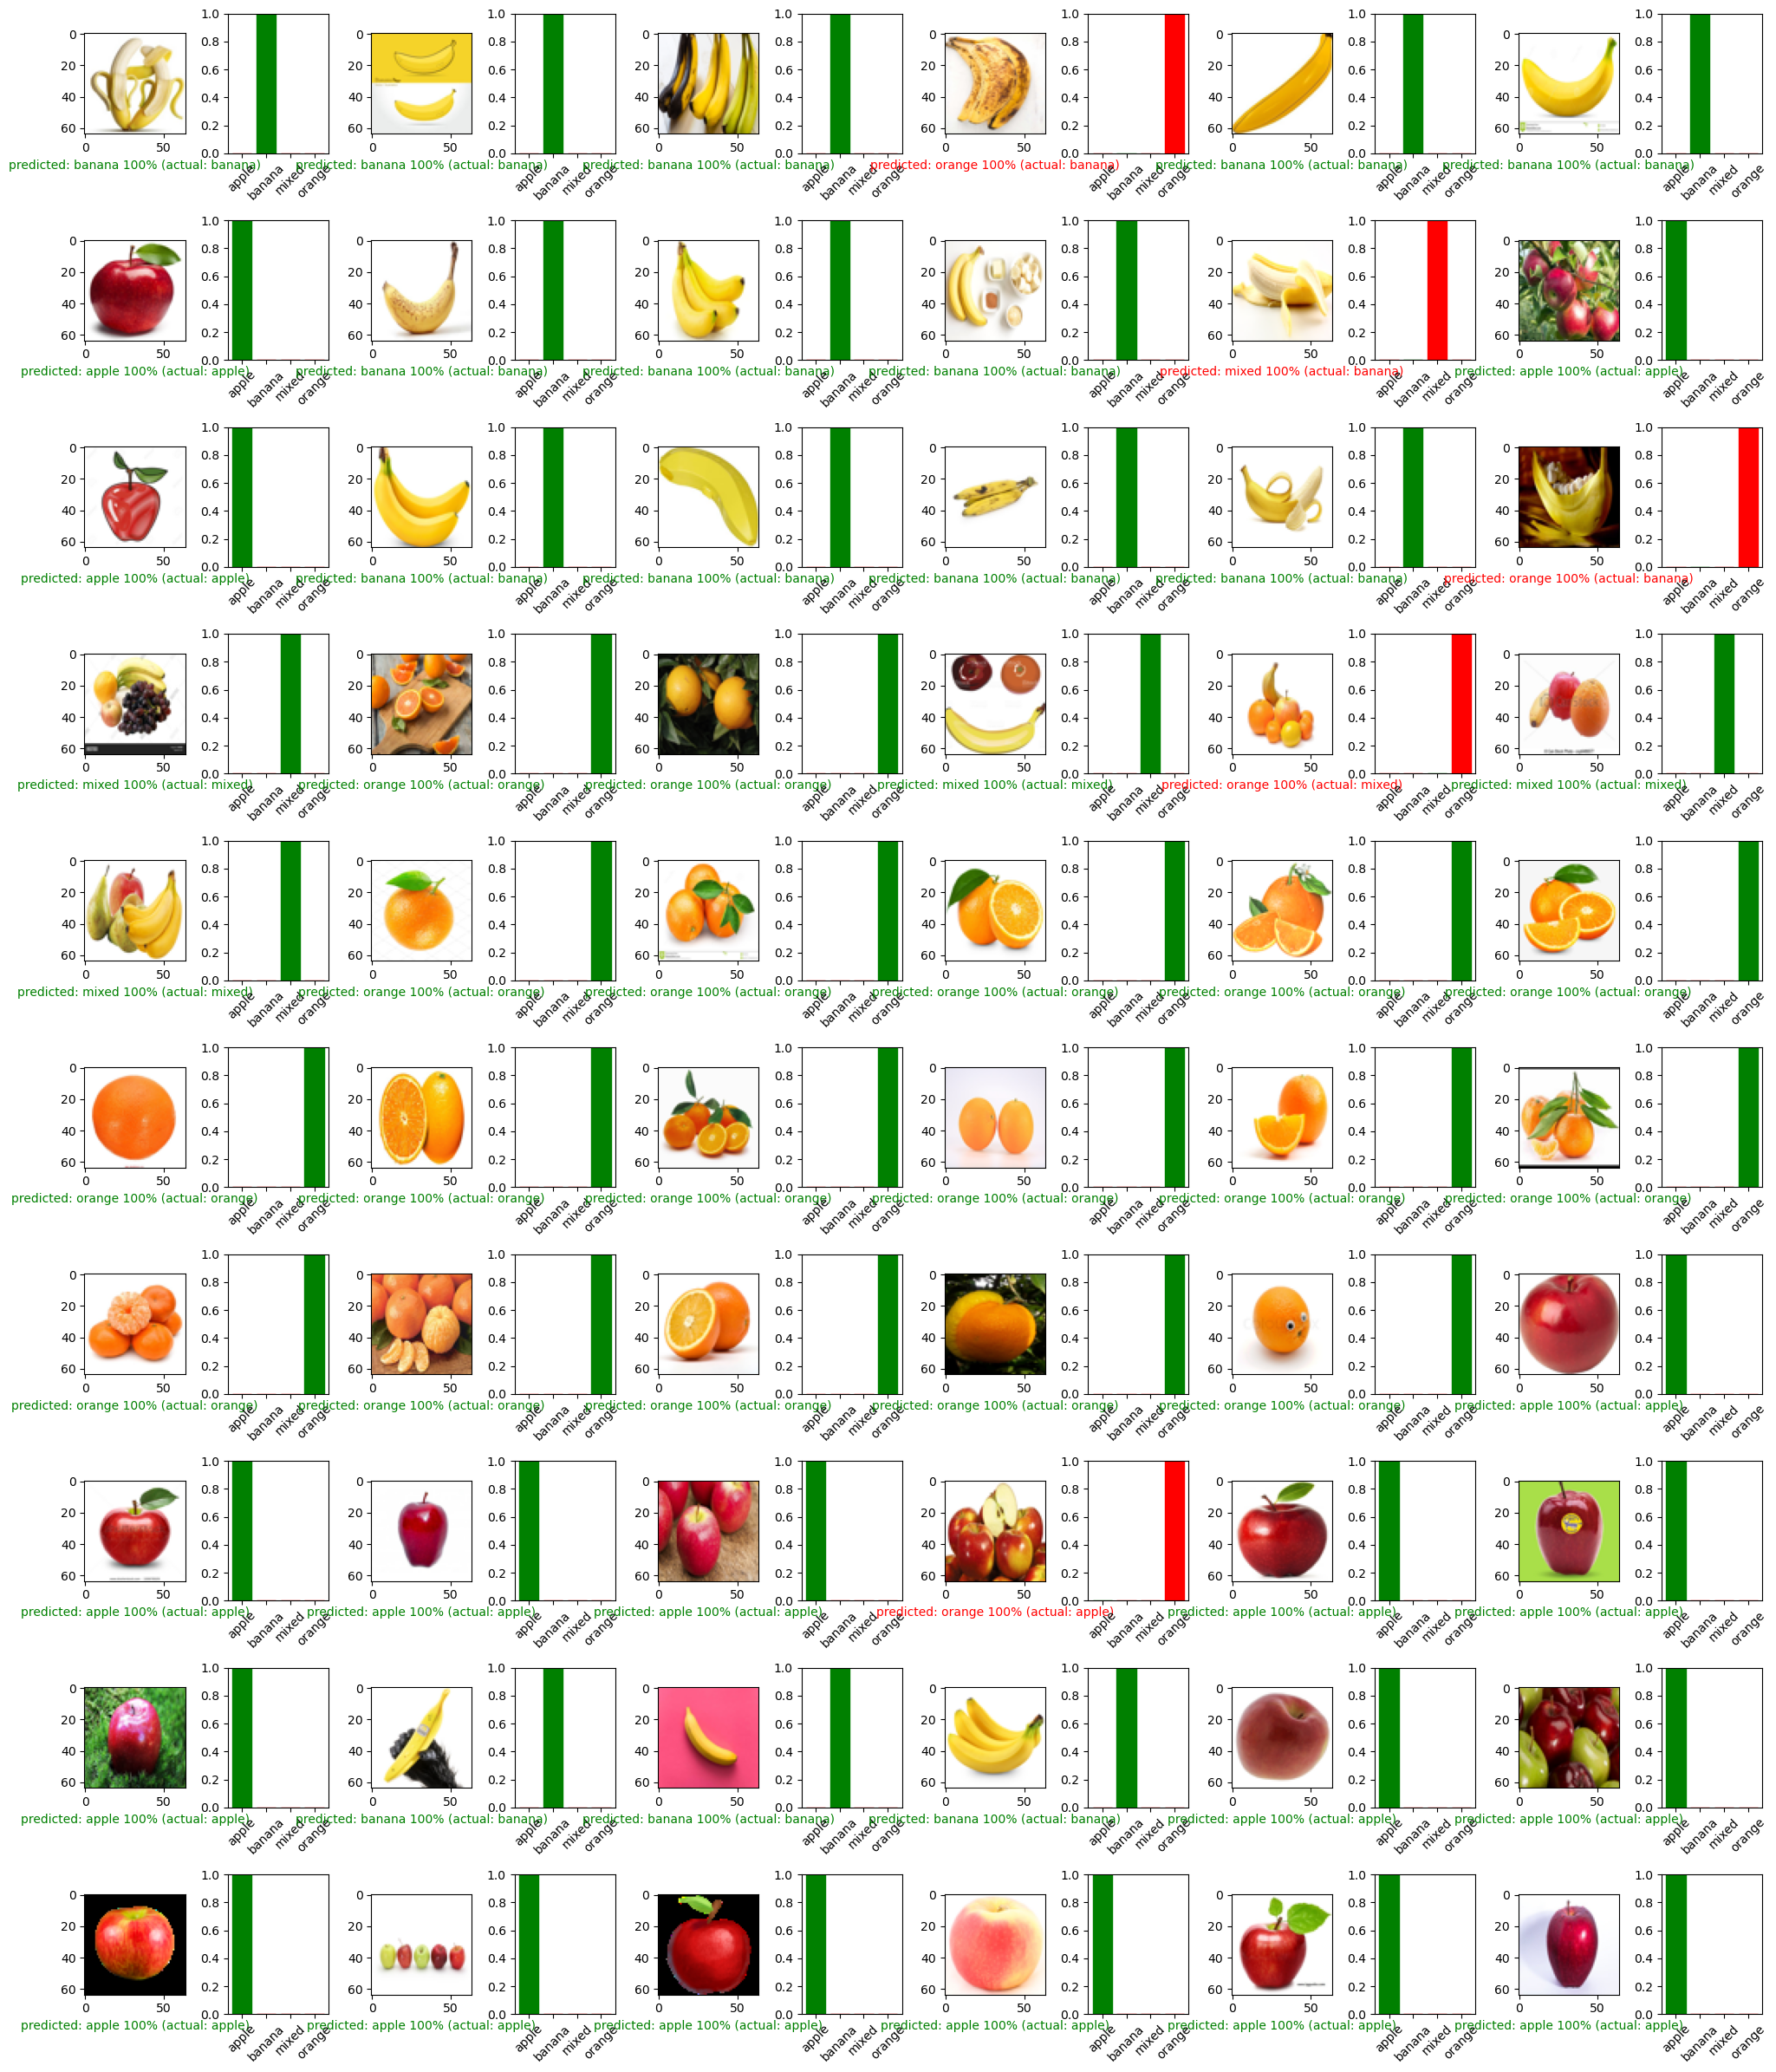

In [329]:
plot_result()

e. Plot images with labels to show accuracy of predictions
==
1. Define function to plot image
2. Define function to plot bar chart to show relative probabilities


In [87]:
def plot_image(i, pred, true_label, test_img):
    plt.grid(False)
    plt.imshow(test_img[i])

    pred_label = np.argmax(pred[i])

    if pred_label == true_label[i]:
        color = 'green'
    else:
        color = 'red'

    plt.xlabel("predicted: {} {:2.0f}% (actual: {})".format(class_names[pred_label],
                                                           100*np.max(pred[i]),
                                                           class_names[true_label[i]]),
                                                           color=color)

In [88]:
def plot_probs(i, pred, true_label):
    plt.xticks(range(4), class_names, rotation=45)
    # cannot take argmax, must take other indices also. EXCEPT the pred.
    # np.delete abit inefficient time wise
    pred_arr = np.arange(0,4,1)
    pred_arr = np.delete(pred_arr, true_label[i])
    plot = plt.bar(range(4),pred[i])
    plt.ylim([0,1])

    for label in pred_arr:
        plot[label].set_color('red')
    plot[true_label[i]].set_color('green')

3. Plot test images with labels and probabilities of prediction

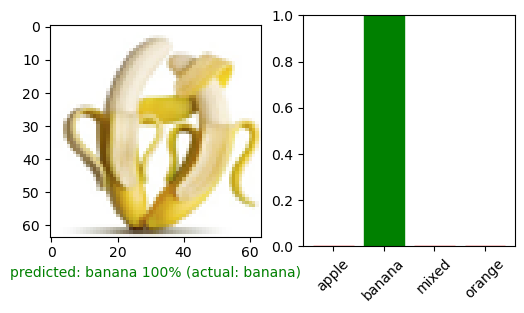

In [270]:
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(0, predictions, y_test, x_test)
plt.subplot(1,2,2)
plot_probs(0, predictions, y_test)
plt.show()

In [210]:
num_rows = 10
num_cols = 6
num_images = num_rows * num_cols

In [211]:
def plot_result():
# 2x figure size
    plt.figure(figsize=(2*num_rows, 2*2*num_cols))
    for i in range(num_images):
        plt.subplot(num_rows, 2*num_cols, 2*i+1)
        plot_image(i, predictions, y_test, x_test)
        plt.subplot(num_rows, 2*num_cols, 2*i+2)
        plot_probs(i, predictions, y_test)
    plt.tight_layout()
    plt.show()

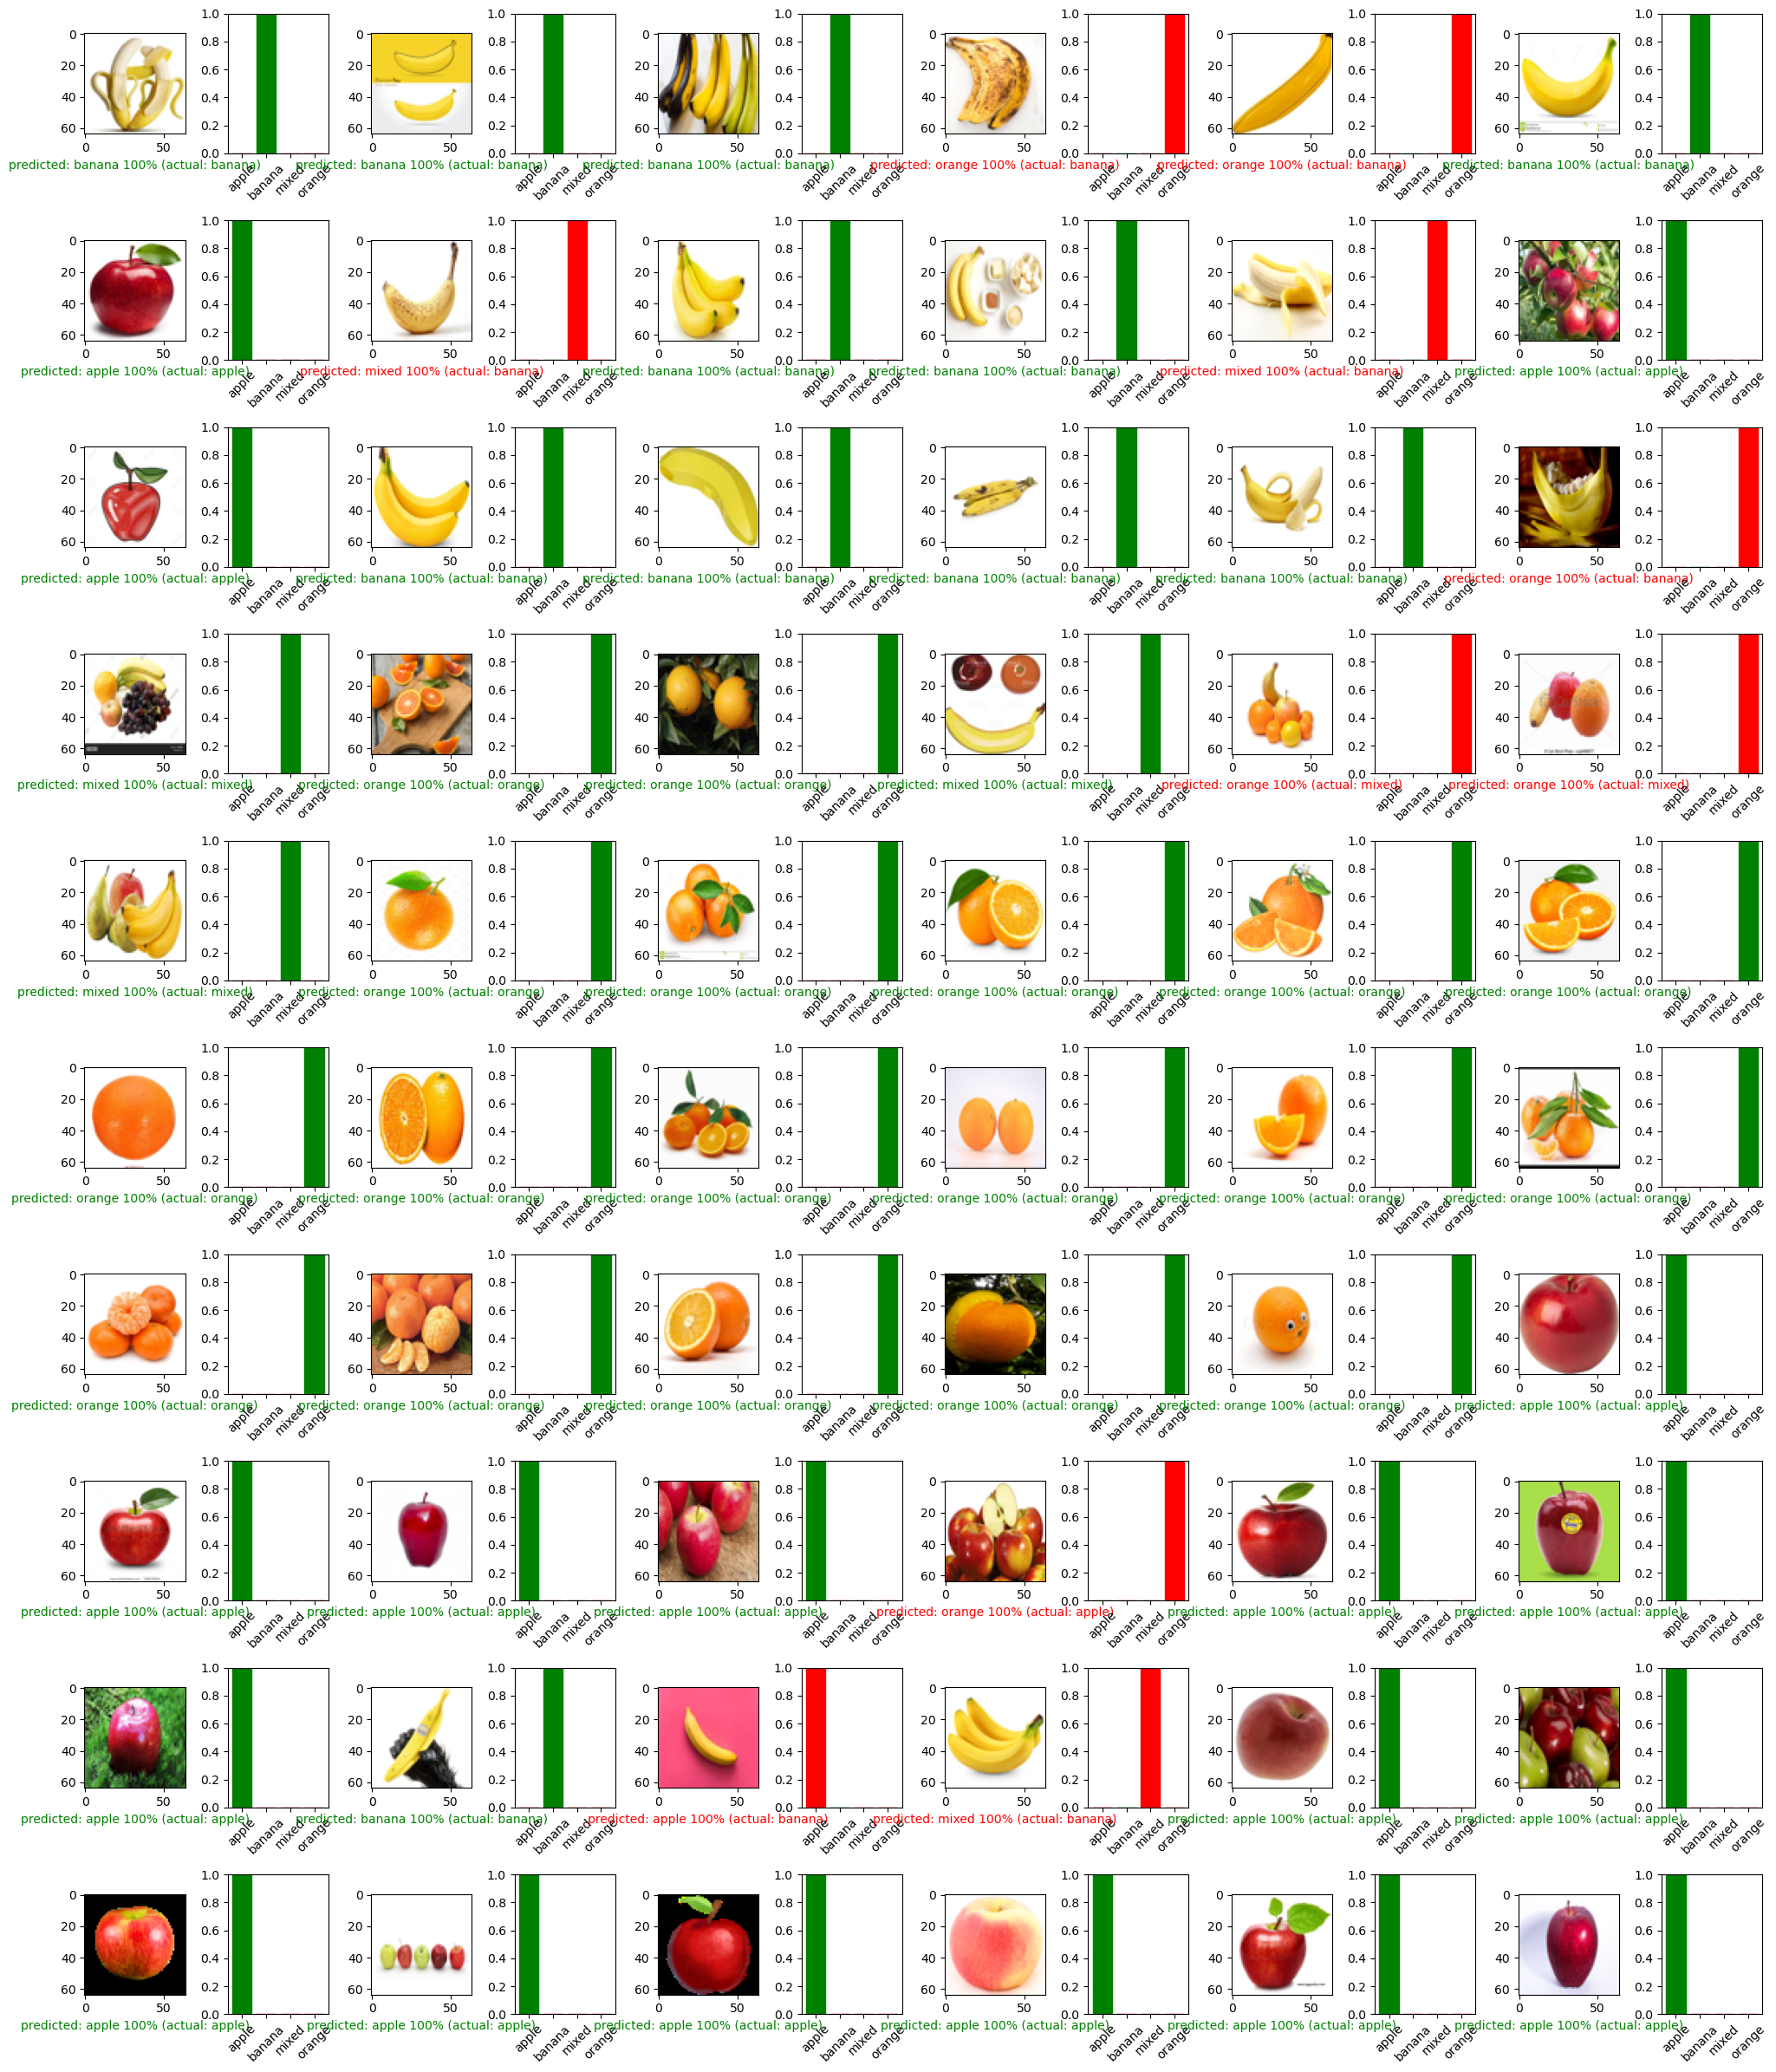

In [212]:
plot_result()
#explore early stopping, pipeline

In [ ]:
# data augmentation

In [218]:
import tensorflow as tf
tf.config.run_functions_eagerly(False)
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [217]:

from tensorflow.python.compiler.mlcompute import mlcompute
mlcompute.set_mlc_device(device_name='gpu')

ModuleNotFoundError: No module named 'tensorflow.python.compiler.mlcompute'